In [1]:
import joblib
from requests import get
import requests
from bs4 import BeautifulSoup
import re
import time
import polars as pl
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

on va automatiser la récupération des données en fonction du patch.

Lets go 



In [ ]:
def get_lol_items():
    # URL du dernier patch
    version_url = "https://ddragon.leagueoflegends.com/api/versions.json"
    latest_version = requests.get(version_url).json()[0]
    
    # URL des données des objets
    url = f"https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/fr_FR/item.json"
    
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        items = data['data']
        
        print(f"Version du patch : {latest_version}")
        print(f"{'ID':<6} | {'Nom objet':<30} | {'Prix total'}")
        print("-" * 50)
        
        for item_id, info in items.items():
            # Filtrer pour ne garder que les objets achetables en magasin
            if info.get('gold', {}).get('purchasable'):
                name = info.get('name')
                total_gold = info.get('gold', {}).get('total')
                print(f"{item_id:<6} | {name:<30} | {total_gold}")
    else:
        print("Erreur lors de la récupération des données.")

if __name__ == "__main__":
    get_lol_items()

Version du patch : 16.1.1
ID     | Nom objet                      | Prix total
--------------------------------------------------
1001   | Bottes                         | 300
1004   | Charme féérique                | 200
1006   | Collier rafraîchissant         | 300
1011   | Ceinture du géant              | 900
1018   | Cape d'agilité                 | 600
1026   | Baguette explosive             | 850
1027   | Cristal de saphir              | 300
1028   | Cristal de rubis               | 400
1029   | Armure d'étoffe                | 300
1031   | Cotte de mailles               | 800
1033   | Cape de néant                  | 400
1036   | Épée longue                    | 350
1037   | Pioche                         | 875
1038   | BF Glaive                      | 1300
1040   | Lame d'obsidienne              | 350
1042   | Dague                          | 250
1043   | Arc courbe                     | 700
1052   | Tome d'amplification           | 400
1053   | Sceptre vampirique             |

Regression taro objet

on met en morceau + récupération

In [2]:
version_url = "https://ddragon.leagueoflegends.com/api/versions.json"
latest_version = requests.get(version_url).json()[0]
url = f"https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/en_US/item.json"
data = requests.get(url).json()['data']

2


In [ ]:

items_list = []
    
    # Mapping des noms barbares de l'API vers des noms simples
stat_map = {
    'FlatPhysicalDamageMod': 'AD',              
    'FlatMagicDamageMod': 'AP',
    'FlatHppoolMod': 'HP',
    'FlatArmorMod': 'Armor',
    'FlatSpellBlockMod': 'MR',
    'PercentAttackSpeedMod': 'AttackSpeed',
    'FlatMovementSpeedMod': 'MoveSpeed'
}

for item_id, info in data.items():
    gold = info.get('gold', {})
    maps = info.get('maps', {}) # On récupère les infos de map

# Les bons objets
        continue

# 2. Filtre Achetable + Prix positif
    if not gold.get('purchasable') or gold.get('total') <= 0:
        continue

#EXTRACTION
    stats = info.get('stats', {})
    row = {'Name': info['name'], 'Gold': gold['total']}
        
# On remplit les stats
    for api_name, simple_name in stat_map.items():
        row[simple_name] = stats.get(api_name, 0)
            
    items_list.append(row)

df = pd.DataFrame(items_list)

In [21]:
feature_cols = ['AD', 'AP', 'HP', 'Armor', 'MR', 'AttackSpeed']
X = df[feature_cols]
y = df['Gold']
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

La partie très fun ou on teste TOUT

In [22]:
#1. Entrainement 
resultat = dict()

dumdum = DummyRegressor()
resultat[dumdum] = cross_val_score(dumdum, X_tr, y_tr)

lr = LinearRegression()
resultat[lr] = cross_val_score(lr, X_tr, y_tr)

la = Lasso(alpha=1.0)
resultat[la] = cross_val_score(la, X_tr, y_tr)

ri = Ridge(alpha=1.0)
resultat[ri] = cross_val_score(ri, X_tr, y_tr)

en = ElasticNet(alpha=1.0, l1_ratio=0.5)
resultat[en] = cross_val_score(en, X_tr, y_tr)

svr = SVR(C=1.0, epsilon=0.1)
resultat[svr] = cross_val_score(svr, X_tr, y_tr)

knr = KNeighborsRegressor(n_neighbors=5)
resultat[knr] = cross_val_score(knr, X_tr, y_tr)

gpr = GaussianProcessRegressor()
resultat[gpr] = cross_val_score(gpr, X_tr, y_tr)

dt = DecisionTreeRegressor()
resultat[dt] = cross_val_score(dt, X_tr, y_tr)

rf = RandomForestRegressor()
resultat[rf] = cross_val_score(rf, X_tr, y_tr)

gb = GradientBoostingRegressor()
resultat[gb] = cross_val_score(gb, X_tr, y_tr)

nn = MLPRegressor(hidden_layer_sizes=(30,), max_iter=10000)
resultat[nn] = cross_val_score(nn, X_tr, y_tr)

resultatdf = pl.from_dict(
    { str(modele): scores for modele, scores in  resultat.items()}
)

resultatdf

print(resultatdf.mean())

C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Marc

shape: (1, 12)
┌────────────┬───────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ DummyRegre ┆ LinearReg ┆ Lasso()  ┆ Ridge()  ┆ … ┆ DecisionT ┆ RandomFor ┆ GradientB ┆ MLPRegres │
│ ssor()     ┆ ression() ┆ ---      ┆ ---      ┆   ┆ reeRegres ┆ estRegres ┆ oostingRe ┆ sor(hidde │
│ ---        ┆ ---       ┆ f64      ┆ f64      ┆   ┆ sor()     ┆ sor()     ┆ gressor() ┆ n_layer_s │
│ f64        ┆ f64       ┆          ┆          ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ize…      │
│            ┆           ┆          ┆          ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---       │
│            ┆           ┆          ┆          ┆   ┆           ┆           ┆           ┆ f64       │
╞════════════╪═══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ -0.018115  ┆ 0.54565   ┆ 0.545662 ┆ 0.539089 ┆ … ┆ 0.519178  ┆ 0.577422  ┆ 0.566577  ┆ 0.57748   │
└────────────┴───────────┴──────────┴──────────┴───┴───────────┴───────────┴

C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: >

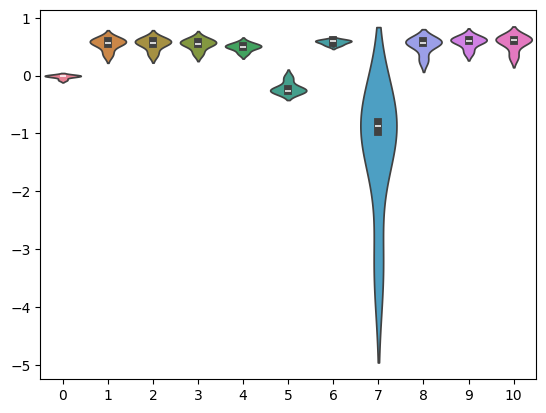

In [23]:
#1. Visualisation des résultats (sous graph)
sns.violinplot(
    data=resultatdf.select(
        pl.exclude("MLPRegressor(hidden_layer_sizes=(30,), max_iter=10000)")
    )
)

Version robuste

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Liste des modèles (couples Nom, Instance)
modeles = [
    ("Dummy (Base)", DummyRegressor()), # Toujours garder lui pour comparer !
    ("Linear", LinearRegression()),
    ("Lasso", Lasso(alpha=1.0)),
    ("Ridge", Ridge(alpha=1.0)),
    ("ElasticNet", ElasticNet(alpha=1.0, l1_ratio=0.5)),
    ("SVR", SVR(C=1.0, epsilon=0.1)),
    ("KNN", KNeighborsRegressor(n_neighbors=5)),
    ("GaussianProcess", GaussianProcessRegressor()),
    ("DecisionTree", DecisionTreeRegressor()),
    ("RandomForest", RandomForestRegressor()),
    ("GradientBoost", GradientBoostingRegressor()),
    ("NeuralNet", MLPRegressor(hidden_layer_sizes=(30,), max_iter=10000))
]

resultats = {}

print("Entraînement en cours...")

for nom, modele in modeles:
    # IMPORTANT : On crée un Pipeline. 
    # D'abord on Scale les données, PUIS on applique le modèle.
    pipe = make_pipeline(StandardScaler(), modele)
    
    scores = cross_val_score(pipe, X_tr, y_tr, cv=5, scoring='neg_mean_absolute_error')
    resultats[nom] = -scores 

# Création du DataFrame Polars
df_res = pl.DataFrame(resultats)

# Affichage des moyennes (classées par la plus petite erreur)
print("\n--- erreur moyenne en gold ---")
moyennes = df_res.mean().transpose(include_header=True, header_name="Modele", column_names=["Erreur_Moyenne"])
print(moyennes.sort("Erreur_Moyenne"))

Entraînement en cours...


C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Marc


--- erreur moyenne en gold ---
shape: (12, 2)
┌─────────────────┬────────────────┐
│ Modele          ┆ Erreur_Moyenne │
│ ---             ┆ ---            │
│ str             ┆ f64            │
╞═════════════════╪════════════════╡
│ RandomForest    ┆ 490.772598     │
│ DecisionTree    ┆ 501.566681     │
│ GradientBoost   ┆ 509.178004     │
│ KNN             ┆ 512.585946     │
│ NeuralNet       ┆ 554.775984     │
│ …               ┆ …              │
│ Ridge           ┆ 594.116138     │
│ ElasticNet      ┆ 720.192871     │
│ SVR             ┆ 919.792183     │
│ Dummy (Base)    ┆ 987.659533     │
│ GaussianProcess ┆ 4638.298897    │
└─────────────────┴────────────────┘


C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


hyperparamètres

In [ ]:
# 1. On définit le modèle (RandomForest cette fois)
rf = RandomForestRegressor(random_state=42)

# 2. On définit la "Grille" des hyperparamètres
# Note : Ça va être un peu plus long car il y a plus de combinaisons
param_grid = {
    'n_estimators': [50, 100, 200],   
    'max_depth': [None, 10, 20],     
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]    
}

# 3. On lance la recherche (GridSearch)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1, # Très important ici : utilise tous tes coeurs CPU pour gérer les arbres
    verbose=1
)

print("Optimisation de la Forêt en cours...")
grid_search.fit(X_tr, y_tr)

# 4. Résultats
best_score = -grid_search.best_score_
best_params = grid_search.best_params_

print(f"\n MEILLEURE COMBINAISON TROUVÉE :")
print(f"Hyperparamètres : {best_params}")
print(f"Erreur Moyenne Optimisée : {best_score:.2f} Gold")

# 5. Récupérer le modèle optimisé
mon_super_modele = grid_search.best_estimator_

Optimisation de la Forêt en cours...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

✅ MEILLEURE COMBINAISON TROUVÉE :
Hyperparamètres : {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Erreur Moyenne Optimisée : 490.96 Gold


on test le modèle sur les données qu'il a jamais vues

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Faire les prédictions
# Le modèle applique tout seul les règles qu'il a apprises
predictions = mon_super_modele.predict(X_te)

# 2. Calculer les scores
mae = mean_absolute_error(y_te, predictions)
r2 = r2_score(y_te, predictions)

print(f"--- RÉSULTATS FINAUX SUR LE TEST SET ---")
print(f" Erreur Moyenne (MAE) : {mae:.2f} Gold")
print(f" Précision (R²)       : {r2:.2f} (1.0 = Parfait, 0.0 = Nul)")

# 3. Créer un tableau comparatif pour voir les erreurs
# On a besoin de remettre l'index à zéro pour coller les colonnes
df_verif = pl.DataFrame({
    "Prix_Reel": y_te.to_numpy(),
    "Prix_Predit": predictions
})

# On calcule l'écart pour chaque objet
df_verif = df_verif.with_columns(
    (pl.col("Prix_Predit") - pl.col("Prix_Reel")).alias("Ecart")
)

# 4. Afficher les plus grosses erreurs (Les objets "chelous")
print("\n--- TOP 5 DES PLUS GROSSES ERREURS ---")
print(df_verif.with_columns(pl.col("Ecart").abs().alias("Abs_Ecart"))
              .sort("Abs_Ecart", descending=True)
              .head(5))

--- RÉSULTATS FINAUX SUR LE TEST SET ---
📉 Erreur Moyenne (MAE) : 437.29 Gold
📊 Précision (R²)       : 0.52 (1.0 = Parfait, 0.0 = Nul)

--- TOP 5 DES PLUS GROSSES ERREURS ---
shape: (5, 4)
┌───────────┬─────────────┬──────────────┬─────────────┐
│ Prix_Reel ┆ Prix_Predit ┆ Ecart        ┆ Abs_Ecart   │
│ ---       ┆ ---         ┆ ---          ┆ ---         │
│ i64       ┆ f64         ┆ f64          ┆ f64         │
╞═══════════╪═════════════╪══════════════╪═════════════╡
│ 3200      ┆ 938.912387  ┆ -2261.087613 ┆ 2261.087613 │
│ 3100      ┆ 938.912387  ┆ -2161.087613 ┆ 2161.087613 │
│ 2800      ┆ 938.912387  ┆ -1861.087613 ┆ 1861.087613 │
│ 2500      ┆ 938.912387  ┆ -1561.087613 ┆ 1561.087613 │
│ 2500      ┆ 938.912387  ┆ -1561.087613 ┆ 1561.087613 │
└───────────┴─────────────┴──────────────┴─────────────┘


visuel

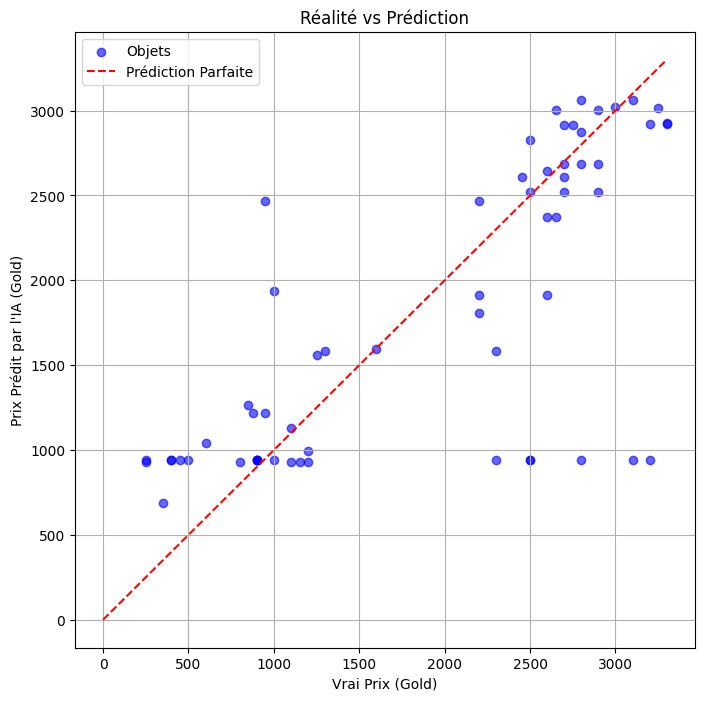

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Nuage de points
plt.scatter(y_te, predictions, alpha=0.6, color='blue', label='Objets')

# Ligne parfaite (x = y)
m = max(y_te.max(), predictions.max())
plt.plot([0, m], [0, m], color='red', linestyle='--', label='Prédiction Parfaite')

plt.xlabel("Vrai Prix (Gold)")
plt.ylabel("Prix Prédit par l'IA (Gold)")
plt.title("Réalité vs Prédiction")
plt.legend()
plt.grid(True)
plt.show()

On va retenir ce modèle là

In [ ]:
# Sauvegarde du modèle avec Joblib
#joblib.dump(mon_super_modele, "modele_prédiction_de_prix.pkl")
